# Time series forecasting

This notebook adapts the Tensorflow tutorial on [Time series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series) to data generated from a model for epidemic processes. 

## Steps

1. Imports and setup
2. Load and prepare the generated data
3. Baseline forecasting
4. Univariate *GRU* based forecasting
5. Multivariate *GRU* based forecasting - Single Step
6. Multivariate *GRU* based forecasting - Multiple Steps

## Imports and setup

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2024-05-29 08:09:46.342860: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-29 08:09:46.343337: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-29 08:09:46.376747: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-29 08:09:46.461387: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 08:09:47.027880: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

## Load and prepare the generated data

We load data from the ODE model introduced in the notebook "Probability and Information Theory". For each of the 150 virtuel outbreaks (randomized and with different model parameters), we have time series (with 500 steps) for four the variables "Susceptible", "Infected", "Recovered", and "Deceased".

In [2]:
csv_path = "../data/epidemic_process_raw_data.csv"
df = pd.read_csv(csv_path)
df.head()

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
0,100.287149,103.541223,95.879814,96.354848,96.980932,97.855310,98.940537,100.187494,98.265709,95.307794,...,4.925236,4.922108,4.918981,4.915853,4.912726,4.950240,4.995291,5.040342,5.085393,5.130445
1,0.993774,1.017558,1.070030,1.116168,1.142078,1.134735,1.182418,1.272310,1.356565,1.438978,...,0.391775,0.384359,0.376942,0.369526,0.362109,0.356669,0.351595,0.346521,0.341447,0.336374
2,0.000000,0.017741,0.036585,0.054735,0.074266,0.096065,0.117691,0.139184,0.163615,0.189006,...,97.247764,96.062916,94.878068,93.693219,92.508371,92.617122,92.965783,93.314443,93.663103,94.011764
3,0.000000,0.000178,0.000364,0.000562,0.000757,0.000947,0.001160,0.001389,0.001635,0.001887,...,0.947347,0.950713,0.954079,0.957445,0.960811,0.959320,0.956929,0.954537,0.952146,0.949755
4,103.489688,100.282780,96.634270,98.532514,99.089272,97.440900,98.416534,101.404903,100.480758,98.277282,...,2.071958,2.064501,2.072213,2.090890,2.109567,2.128244,2.146921,2.165597,2.184274,2.202951


In [3]:
dfSusceptible = df[df.index % 4 == 0]
dfSusceptible.head()

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
0,100.287149,103.541223,95.879814,96.354848,96.980932,97.855310,98.940537,100.187494,98.265709,95.307794,...,4.925236,4.922108,4.918981,4.915853,4.912726,4.950240,4.995291,5.040342,5.085393,5.130445
4,103.489688,100.282780,96.634270,98.532514,99.089272,97.440900,98.416534,101.404903,100.480758,98.277282,...,2.071958,2.064501,2.072213,2.090890,2.109567,2.128244,2.146921,2.165597,2.184274,2.202951
8,101.527421,97.711732,96.168179,95.677962,95.575326,96.109792,96.943831,98.007655,98.132798,97.951008,...,48.629414,48.662862,48.696309,48.729757,48.763204,48.796652,48.830099,48.863547,48.896994,48.930442
12,101.061107,99.112815,106.651686,101.622904,97.726686,95.692173,97.438263,102.084252,101.831030,99.975843,...,3.890526,3.869629,3.894123,3.928628,3.963133,3.997638,4.032143,4.066648,4.101153,4.135658
16,101.957189,101.898022,100.881113,99.892000,98.939878,98.048565,98.220024,99.206678,99.067041,98.559123,...,5.878943,5.910111,5.941279,5.959441,5.860292,5.761142,5.667567,5.680109,5.692651,5.705193


In [4]:
dfInfected = df[df.index % 4 == 1]
dfInfected.head()

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
1,0.993774,1.017558,1.070030,1.116168,1.142078,1.134735,1.182418,1.272310,1.356565,1.438978,...,0.391775,0.384359,0.376942,0.369526,0.362109,0.356669,0.351595,0.346521,0.341447,0.336374
5,1.021677,1.045410,1.120324,1.175914,1.236878,1.306676,1.387931,1.477973,1.549873,1.615840,...,0.172933,0.171653,0.169739,0.167366,0.164993,0.162620,0.160247,0.157874,0.155501,0.153128
9,1.020043,1.011238,1.031122,1.048642,1.049479,1.022891,1.035862,1.079177,1.114531,1.147282,...,5.658505,5.625406,5.592308,5.559209,5.526111,5.493012,5.459914,5.426815,5.393717,5.360619
13,1.035248,1.014189,1.133178,1.135622,1.157984,1.213088,1.281406,1.359858,1.423234,1.481680,...,0.297238,0.292756,0.288433,0.284145,0.279857,0.275569,0.271280,0.266992,0.262704,0.258416
17,1.012666,1.016949,1.053194,1.097599,1.143640,1.192369,1.238880,1.283688,1.324305,1.363552,...,0.475822,0.467301,0.458779,0.450518,0.444609,0.438701,0.432715,0.425247,0.417780,0.410313


In [5]:
dfRecovered = df[df.index % 4 == 2]
dfRecovered.head()

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
2,0.0,0.017741,0.036585,0.054735,0.074266,0.096065,0.117691,0.139184,0.163615,0.189006,...,97.247764,96.062916,94.878068,93.693219,92.508371,92.617122,92.965783,93.314443,93.663103,94.011764
6,0.0,0.017909,0.035748,0.056118,0.076620,0.097338,0.119592,0.143024,0.171253,0.201050,...,96.481711,97.126839,97.050590,96.452872,95.855153,95.257435,94.659716,94.061998,93.464279,92.866561
10,0.0,0.016990,0.034644,0.052866,0.071444,0.090609,0.108733,0.126058,0.142408,0.158437,...,45.237808,45.424013,45.610219,45.796424,45.982629,46.168835,46.355040,46.541246,46.727451,46.913657
14,0.0,0.017002,0.036315,0.057484,0.078381,0.098831,0.119563,0.140509,0.166486,0.194109,...,92.875601,92.371850,92.874094,93.598211,94.322327,95.046444,95.770560,96.494677,97.218794,97.942910
18,0.0,0.017589,0.037434,0.056572,0.076275,0.096907,0.116533,0.135387,0.157592,0.180893,...,93.437562,93.064191,92.690821,92.516054,94.132580,95.749106,97.237129,96.278611,95.320093,94.361575


In [6]:
dfDead = df[df.index % 4 == 3]
dfDead.head()

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
3,0.0,0.000178,0.000364,0.000562,0.000757,0.000947,0.001160,0.001389,0.001635,0.001887,...,0.947347,0.950713,0.954079,0.957445,0.960811,0.959320,0.956929,0.954537,0.952146,0.949755
7,0.0,0.000175,0.000351,0.000558,0.000763,0.000968,0.001196,0.001443,0.001719,0.002004,...,0.989016,0.987952,0.986532,0.984855,0.983178,0.981502,0.979825,0.978148,0.976471,0.974794
11,0.0,0.000171,0.000352,0.000538,0.000729,0.000927,0.001126,0.001324,0.001488,0.001642,...,0.454590,0.455255,0.455920,0.456585,0.457250,0.457914,0.458579,0.459244,0.459909,0.460574
15,0.0,0.000181,0.000364,0.000563,0.000774,0.001003,0.001192,0.001351,0.001575,0.001822,...,0.951079,0.954145,0.954334,0.953888,0.953443,0.952997,0.952552,0.952106,0.951661,0.951215
19,0.0,0.000180,0.000358,0.000550,0.000740,0.000931,0.001138,0.001359,0.001574,0.001787,...,0.975329,0.959467,0.943605,0.929243,0.928406,0.927568,0.927127,0.934226,0.941326,0.948426


Below a plot of three infection time series for the three first outbreaks.

<AxesSubplot:>

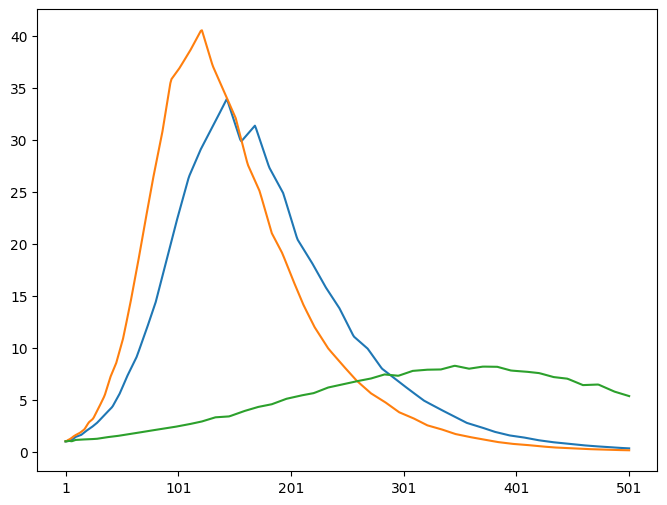

In [7]:
dfInfected.loc[1,:].plot()
dfInfected.loc[5,:].plot()
dfInfected.loc[9,:].plot()

We define a 90% / 10% of data for training / testing.

In [8]:
dfInfected_arr = dfInfected.values
dfInfected_arr.shape
TRAIN_SPLIT = int(dfInfected_arr.shape[0]-dfInfected_arr.shape[0]*0.1)
TRAIN_SPLIT

135

We standardize the data.

In [9]:
uni_train_mean = dfInfected_arr[:TRAIN_SPLIT].mean()
uni_train_std = dfInfected_arr[:TRAIN_SPLIT].std()
uni_data = (dfInfected_arr-uni_train_mean)/uni_train_std
print ('\n Univariate data shape')
print(uni_data.shape)


 Univariate data shape
(150, 501)


We split the data into time series of `univariate_past_history=20` days length and predict the future of the current day, i.e., `univariate_future_target=0`, for the "infected" variable. 

In [10]:
def univariate_data(dataset, start_series, end_series, history_size, target_size):
    data = []
    labels = []
    start_index = history_size
    end_index = len(dataset[0]) - target_size   
    for c in range(start_series, end_series):
        for i in range(start_index, end_index):
            indices = range(i-history_size, i)
            # Reshape data from (history_size,) to (history_size, 1)
            data.append(np.reshape(dataset[c][indices], (history_size, 1)))
            labels.append(dataset[c][i+target_size])
    return np.array(data), np.array(labels)

In [11]:
univariate_past_history = 20 #days
univariate_future_target = 0 #current day

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, len(uni_data),
                                       univariate_past_history,
                                       univariate_future_target)

In [12]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target number to predict')
print (y_train_uni[0])
print ('\n Number of traing data points')
print (y_train_uni.shape[0])
print ('\n Number of test data points')
print (x_val_uni.shape[0])

Single window of past history
[[-0.95291296]
 [-0.95044298]
 [-0.94499366]
 [-0.9402021 ]
 [-0.93751136]
 [-0.93827393]
 [-0.93332191]
 [-0.92398652]
 [-0.91523643]
 [-0.90667772]
 [-0.90243571]
 [-0.89846308]
 [-0.89449045]
 [-0.89051782]
 [-0.88593997]
 [-0.87701137]
 [-0.86808277]
 [-0.85915417]
 [-0.85022557]
 [-0.84167481]]

 Target number to predict
-0.8339932964893617

 Number of traing data points
64935

 Number of test data points
7215


In [13]:
def create_time_steps(length):
    return list(range(-length, 0))

In [14]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/media/home/ngundermann/workspace/DML_notebooks/venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

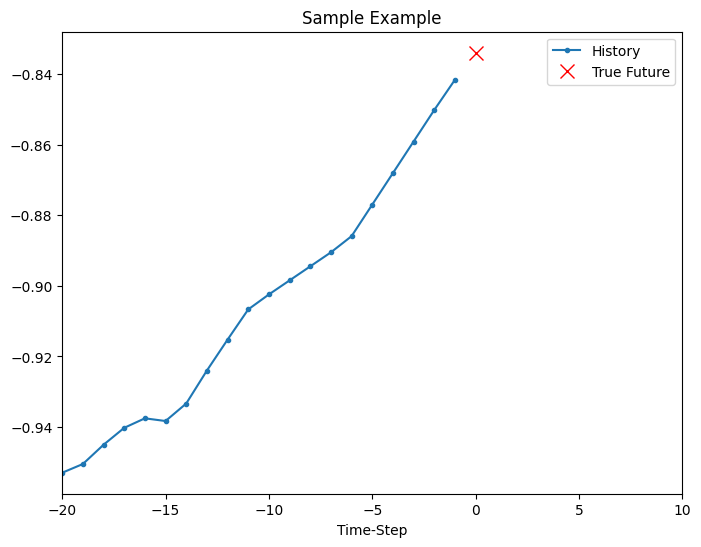

In [15]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

## Baseline forecasting

Predicts the mean of the `history`.

In [16]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/media/home/ngundermann/workspace/DML_notebooks/venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

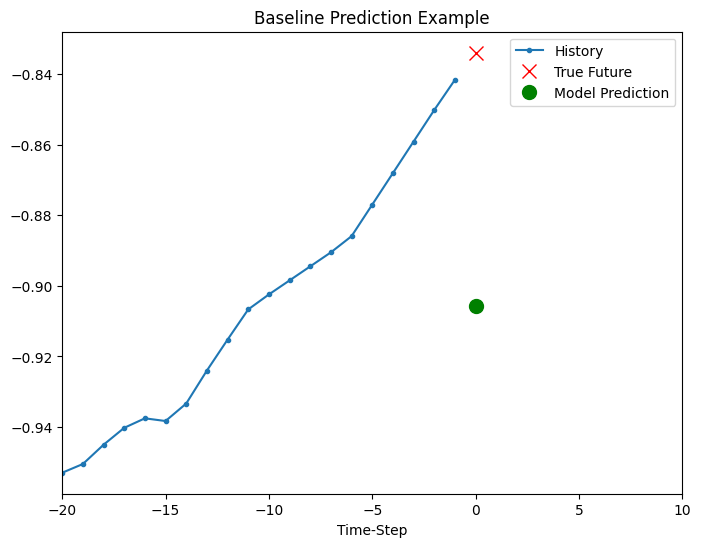

In [17]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example')

## Univariate *GRU* based forecasting

In [18]:
print (x_train_uni.shape)
print (y_train_uni.shape)
x_train_uni.dtype

(64935, 20, 1)
(64935,)


dtype('float64')

Batching and resampling; the dataset is repeated indefinitely. Check the tutorial for the details.

In [19]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

train_univariate

2024-05-29 08:09:48.536911: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-29 08:09:48.548027: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


<_RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

We define the first *GRU* model with 8 units.

In [20]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')
simple_lstm_model.summary()
x_train_uni.shape[-2:]

/media/home/ngundermann/workspace/DML_notebooks/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273 (1.07 KB)

 Trainable params: 273 (1.07 KB)

 Non-trainable params: 0 (0.00 B)

(20, 1)

*The GRU layer comes with less parameters than the LSTM layer (320) we have seen in the original notebook. This is becaust the GRU architecture is much simpler than LSTMs'.*

In [21]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)
    print(y.shape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


(256, 1)
(256,)


2024-05-29 08:09:48.776884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


When passing an indefinitely repeated training data set, we need to specify the numbre of steps per training interval (epoch).

In [22]:
EVALUATION_INTERVAL = 2000
EPOCHS = 10

simple_lstm_model.fit(train_univariate, 
                      epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, 
                      validation_steps=50)

Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1910 - val_loss: 0.0031
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0038 - val_loss: 0.0027
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0022 - val_loss: 0.0036
Epoch 9/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 10/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0021 - val_loss: 0.0019


*The training loss went down very fast and convereged after a few epochs. However, the validation loss stated very low at the beginning, and did not change that much, which might indicate overfitting. Anyway, the training of one epoch finished faster, which could be caused by the fewer parameters of the model but also by the different machine on that the training was ran.*

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


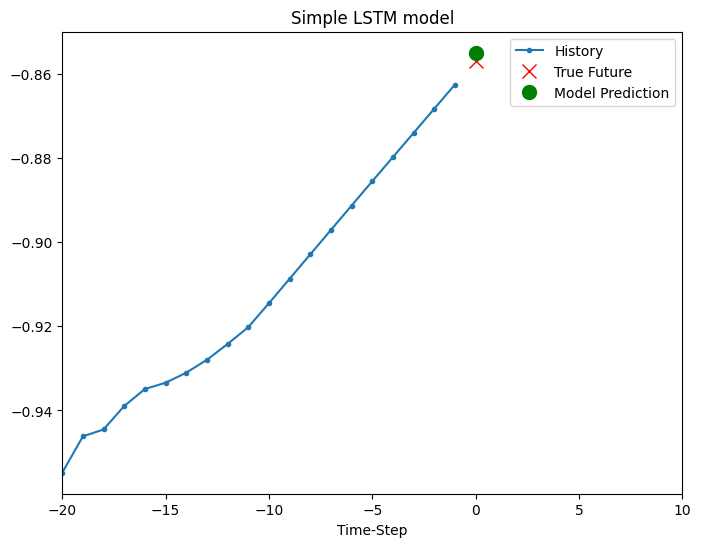

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


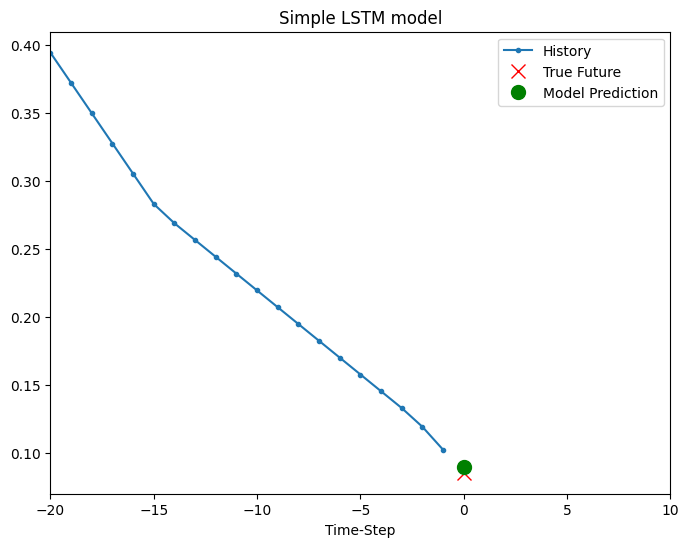

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


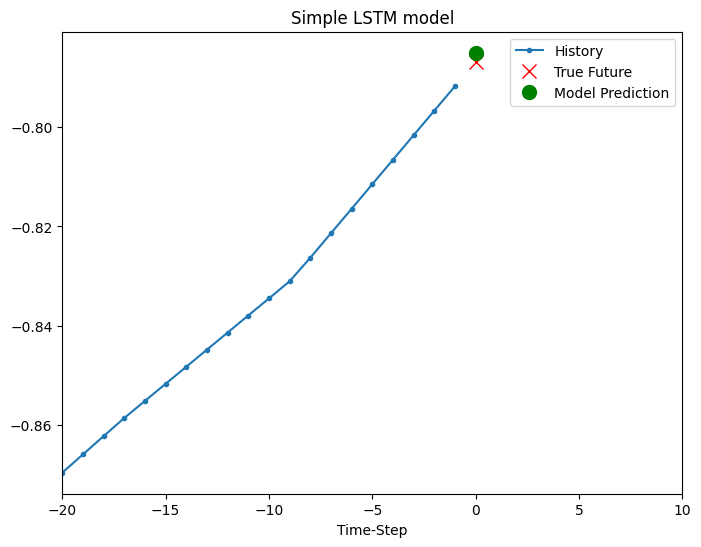

2024-05-29 08:10:55.817762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

*Even if I assumed some overfitting here, the predictions look quite good, since the validataion loss was quite low the whole time. The prediction are not exactly at the true value, but very close to it.*

## Multivariate *GRU* based forecasting - Single Step

We use three variables "Infected", "Recovered", and "Deceased", to forcast "Infected" at one single day in the future.

Here a plot of the time series of the three variables for one outbreak. 

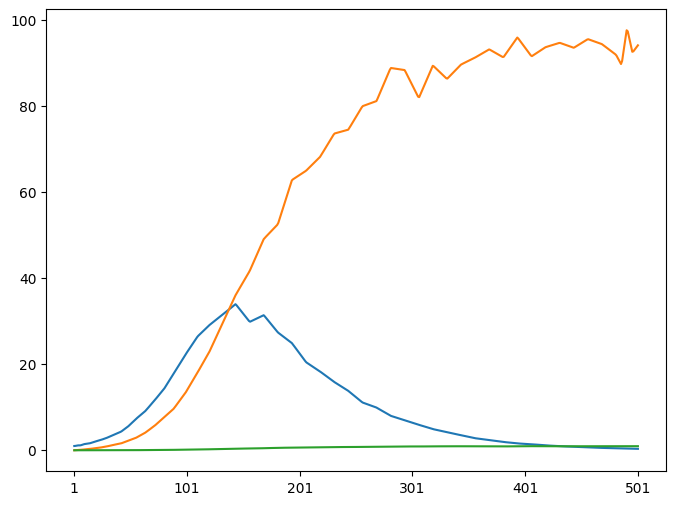

In [24]:
dfInfected.loc[1,:].plot()
dfRecovered.loc[2,:].plot()
dfDead.loc[3,:].plot()
dfInfected = dfInfected.values
dfRecovered_arr = dfRecovered.values
dfDead_arr = dfDead.values

We prepare the dataset.

In [25]:
#as before
dfInfected_train_mean = dfInfected_arr[:TRAIN_SPLIT].mean()
dfInfected_train_std = dfInfected_arr[:TRAIN_SPLIT].std()
dfInfected_data = (dfInfected_arr-dfInfected_train_mean)/dfInfected_train_std
#for Recovered
dfRecovered_train_mean = dfRecovered_arr[:TRAIN_SPLIT].mean()
dfRecovered_train_std = dfRecovered_arr[:TRAIN_SPLIT].std()
dfRecovered_data = (dfRecovered_arr-dfRecovered_train_mean)/dfRecovered_train_std
#for Dead
dfDead_train_mean = dfDead_arr[:TRAIN_SPLIT].mean()
dfDead_train_std = dfDead_arr[:TRAIN_SPLIT].std()
dfDead_data = (dfDead_arr-dfDead_train_mean)/dfDead_train_std

In [26]:
dataset = np.array([dfInfected_data, dfRecovered_data, dfDead_data])
dataset.shape
print ('\n Multivariate data shape')
print(dataset.shape)


 Multivariate data shape
(3, 150, 501)


In [27]:
def multivariate_data(dataset, target, start_series, end_series, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    start_index = history_size
    end_index = len(dataset[0][0]) - target_size   
    for c in range(start_series, end_series):
        for i in range(start_index, end_index):
            indices = range(i-history_size, i, step)
            one = dataset[0][c][indices]
            two = dataset[1][c][indices]
            three = dataset[2][c][indices]
            data.append(np.transpose(np.array([one, two, three])))
            
            if single_step:
                labels.append(target[c][i+target_size])
            else:
                labels.append(np.transpose(target[c][i:i+target_size]))
    return np.array(data), np.array(labels)

We get training and valdation data for time series with a `past_history = 20` days for every other day (`STEP = 2`) and want to predict the "Infected" five days ahead (`future_target = 5`).

In [28]:
past_history = 20
future_target = 5
STEP = 2

x_train_single, y_train_single = multivariate_data(dataset, dfInfected_data, 0, TRAIN_SPLIT, 
                                                   past_history, future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dfInfected_data, TRAIN_SPLIT, dataset.shape[1], 
                                               past_history, future_target, STEP,
                                               single_step=True)

In [29]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))
print(dataset.shape)

Single window of past history : (10, 3)
(3, 150, 501)


As before, batching and resampling; the dataset is repeated indefinitely.

In [30]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [31]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.GRU(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
single_step_model.summary()
x_train_single.shape[-2:]

/media/home/ngundermann/workspace/DML_notebooks/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 32)             │         3,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,585 (14.00 KB)

 Trainable params: 3,585 (14.00 KB)

 Non-trainable params: 0 (0.00 B)

(10, 3)

*Again we got a network with fewer parameters, since the GRU architecture comes with less parameters than the LSTM architecture.*

In [32]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)
print ('\n Number of traing data points')
print (x_train_single.shape[0])
print ('\n Number of test data points')
print (x_val_single.shape[0])

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
(256, 1)

 Number of traing data points
64260

 Number of test data points
7140


2024-05-29 08:10:56.473071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [33]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0838 - val_loss: 0.0275
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0276 - val_loss: 0.0224
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0237 - val_loss: 0.0204
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0212 - val_loss: 0.0162
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0195 - val_loss: 0.0189
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0183 - val_loss: 0.0171
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0175 - val_loss: 0.0161
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0170 - val_loss: 0.0148
Epoch 9/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0164 - val_loss: 0.0122
Epoch 10/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0159 - val_loss: 0.0148


In [34]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

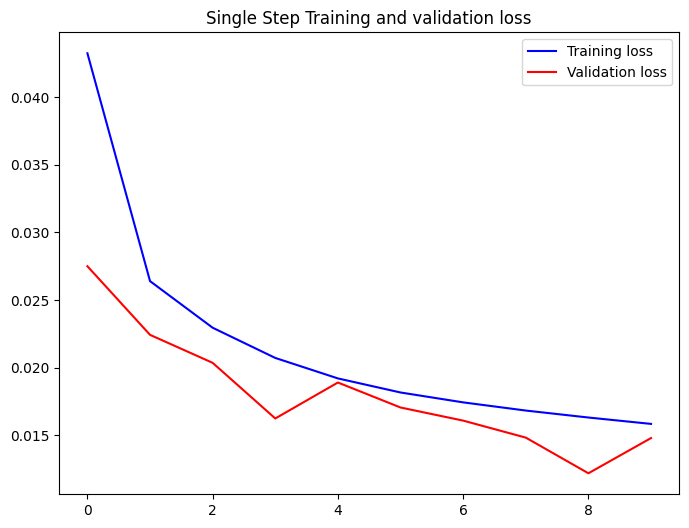

In [35]:
plot_train_history(single_step_history,'Single Step Training and validation loss')

*Here, we see once again a big decrease in training loss at the very beginning. However, here, the validation loss tend to shrink next to the training loss, which could indicate that the resulting network will not suffer from overfitting and is, thus, more general compared to the previous one. Moreover, I think the training needs some more epochs in order to let the loss converge at a certain value. This was probably not reached after 10 epochs.*

*According to time, once again it was a little bit fast than the training of the model from the original notebook, which could be due to the architecture coming with fewer parameters but also to the different machine on that the training was ran.*

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


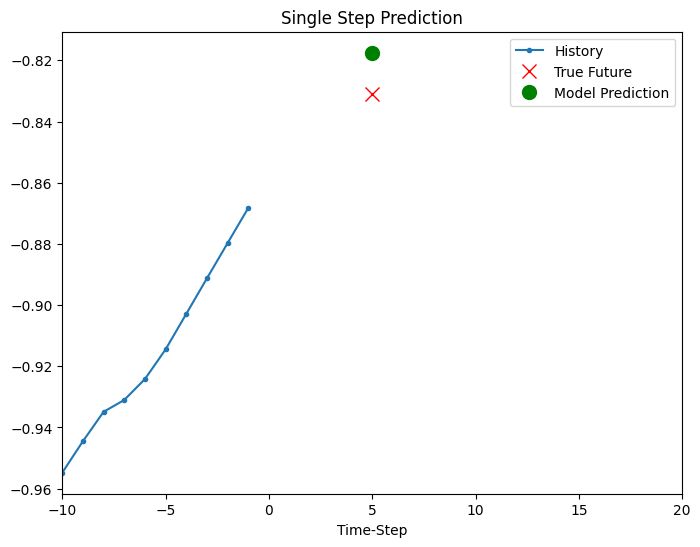

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step


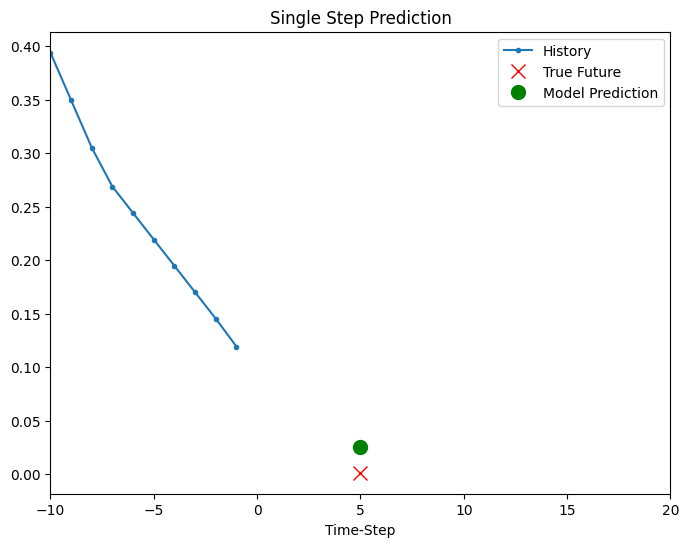

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step


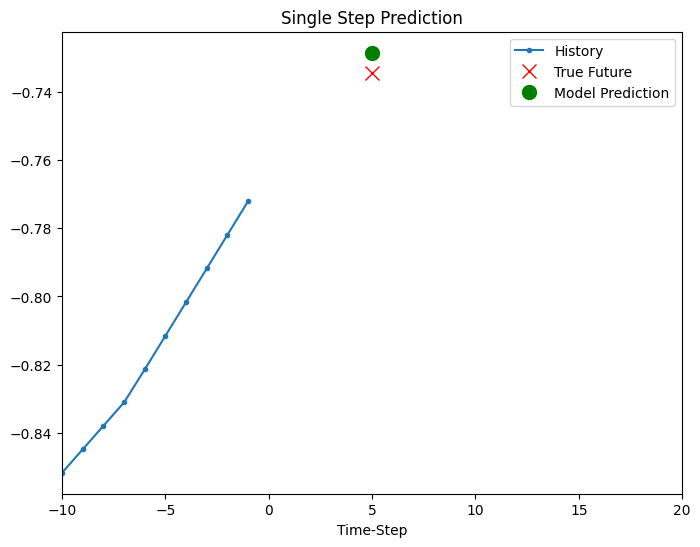

2024-05-29 08:12:05.126416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [36]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], future_target,
                   'Single Step Prediction')
    plot.show()

*Looking at the predictions they a a bit worse compared to the previous model. Here, we have to keep in mind, that both models performed different predicitons. Here, we wanted to predict the 5 day future, while with the first model we wanted to predict the 1 day future. So maybe the error, we have seen in the previous model is likely to add up when the number of days we want to forcast into the future increases. Anyway, that the prediction is worse than in the preivous model, could have been noticed when comparing the validation loss of the models.*

## Multivariate *GRU* - Multiple Steps

Still, we use a series of observed values of the three variables "Infected", "Recovered", and "Deceased" (`past_history = 40, STEP =2`), but now to forcast the "Infected" values for a series day in the future (`future_target = 10`).

In [37]:
past_history = 40
future_target = 10
STEP =2
x_train_multi, y_train_multi = multivariate_data(dataset, dfInfected_data, 0, TRAIN_SPLIT, 
                                                    past_history, future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dfInfected_data, TRAIN_SPLIT, dataset.shape[1], 
                                                past_history, future_target, STEP)

In [38]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\nTarget window to predict : {}'.format(y_train_multi[0].shape))
print ('\nNumber of traing data points: {}'.format(x_train_multi.shape[0]))
print ('\nNumber of test data points: {}'.format(x_val_multi.shape[0]))

Single window of past history : (20, 3)

Target window to predict : (10,)

Number of traing data points: 60885

Number of test data points: 6765


As before, batching and resampling; the dataset is repeated indefinitely.

In [39]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [40]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(num_out), np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out), np.array(prediction), 'ro', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

2024-05-29 08:12:05.733761: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


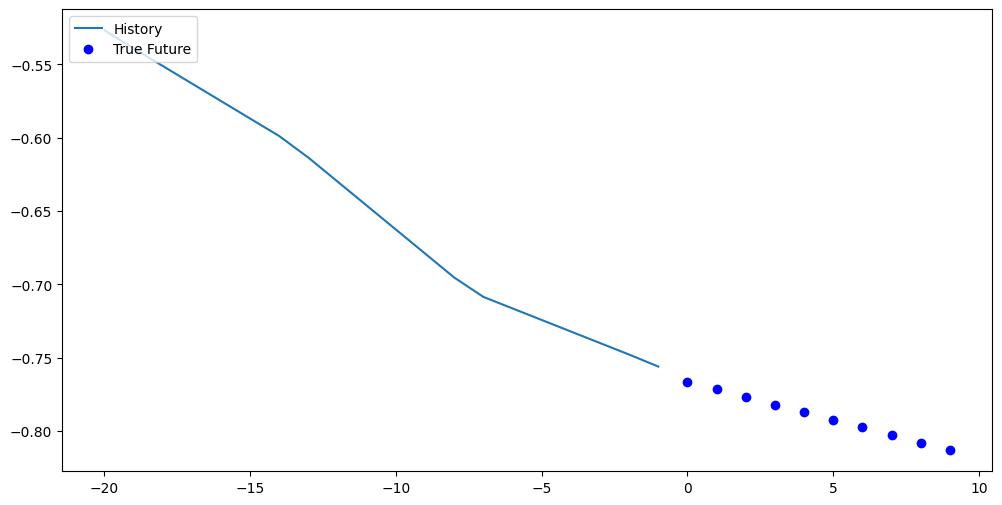

2024-05-29 08:12:05.783186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [41]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

Now we bild a model with two *GRU* layers.

In [42]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.GRU(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.GRU(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
multi_step_model.summary()
x_train_multi.shape[-2:]

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 20, 32)         │         3,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 16)             │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,122 (23.91 KB)

 Trainable params: 6,122 (23.91 KB)

 Non-trainable params: 0 (0.00 B)

(20, 3)

*As before, we observe that the number of parameter is smaller compared to the model with the LSTM layers, due to the different architectures.*

In [43]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
(256, 10)


2024-05-29 08:12:05.977410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


The training time is longer for this more complex model.

In [44]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.1187 - val_loss: 0.0223
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0281 - val_loss: 0.0230
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.0240 - val_loss: 0.0247
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - loss: 0.0218 - val_loss: 0.0172
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - loss: 0.0202 - val_loss: 0.0180
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 0.0191 - val_loss: 0.0165
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - loss: 0.0180 - val_loss: 0.0172
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - loss: 0.0172 - val_loss: 0.0150
Epoch 9/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 0.0168 - val_loss: 0.0147
Epoch 10/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0164 - val_loss: 0.0144


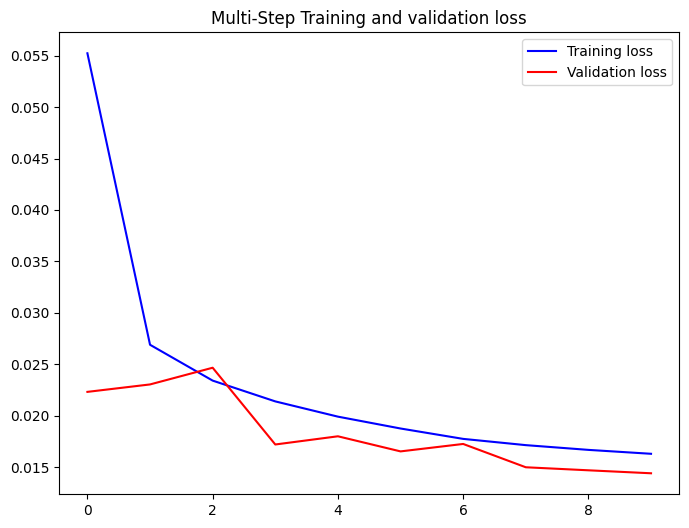

In [45]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

*Here, we see once again a big decrease in training loss at the very beginning. The validation loss tend to shrink next to the training loss, which could indicate that the resulting network will not suffer from overfitting. Moreover, it is possible that the training needs some more epochs in order to let the loss converge at a certain value. However, the situation here looks quite better (regarding to that the model already reached to optimum ) compared to the previous model.*

*According to time, the training was slower compared to the other models. This is due to the more complex architecture which come with more parameters and , thus, a higher computational effort. Anyway, once again it was a little bit fast than the training of the model from the original notebook, which could be due to the architecture coming with fewer parameters but also to the different machine on that the training was ran.*

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


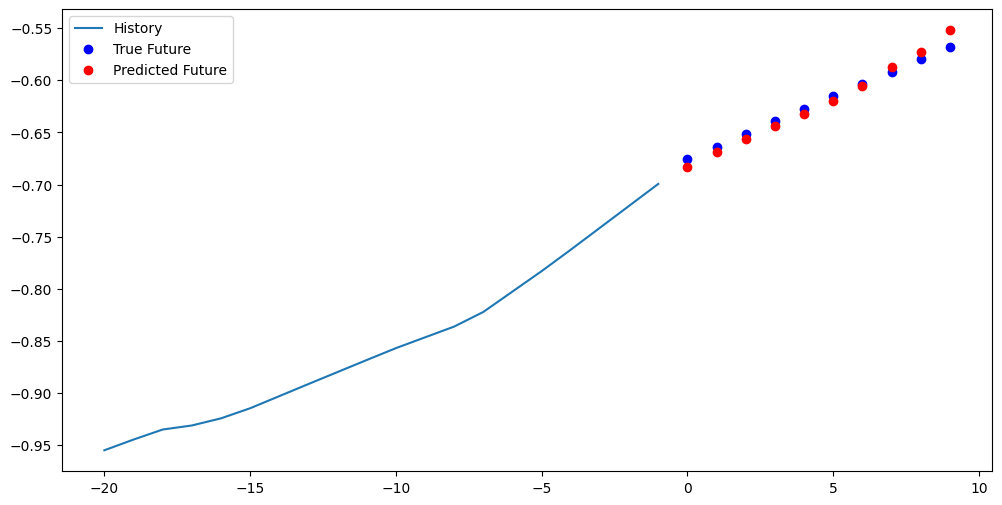

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


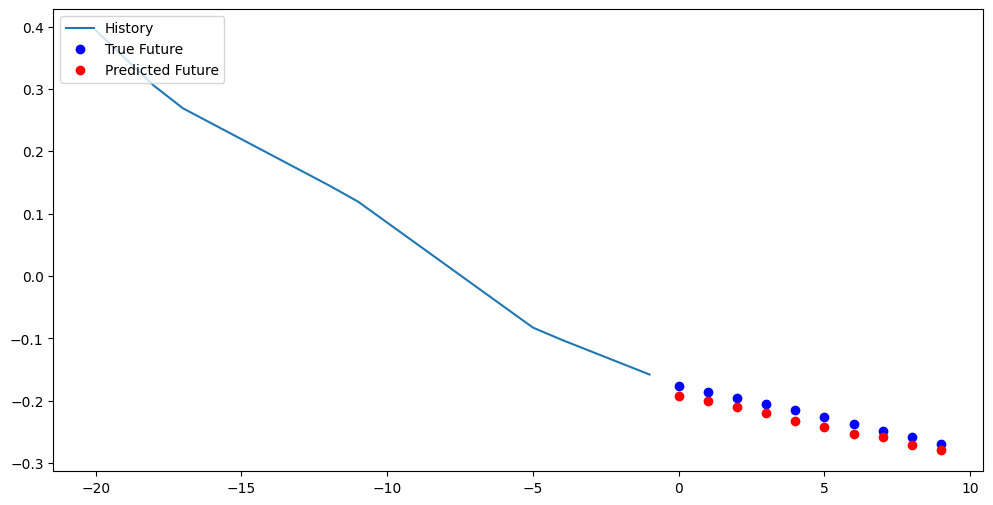

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


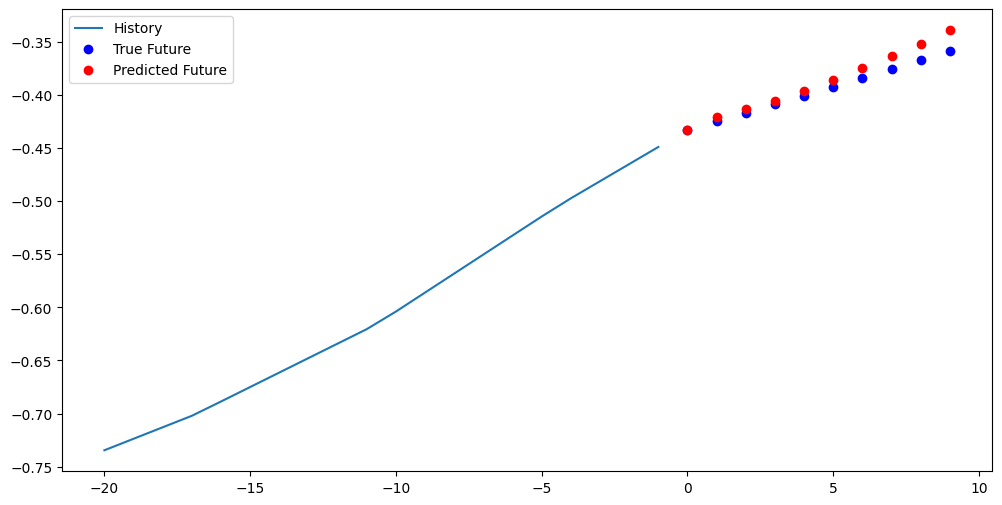

2024-05-29 08:15:44.801662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [46]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

*Looking at the predictions they are quite good. In some cases, one sees that the difference between true value and prediction is larger when forcasting is made for a more distant future. However, this does not hold for the second example.*